# 크리스마스시즌에 많이 팔리는 특정 색상군, 패턴, 형태, 종류

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

art = pd.read_csv("data/art_processed.csv")                 # 상품 메타데이터
cust = pd.read_csv("data/cust_processed.csv")               # 고객 메타데이터
total_revenue = pd.read_csv("data/total_revenue.csv")       # 매출 데이터

In [2]:
# # ---------------------------------------------------------------------
# 분석용 통합 테이블 거래+고객+상품
# 볼수 있는 데이터
# ==  거래(매출, 채널, 날짜, 고객그룹) + 고객속성 + 상품속성
# 가입한 사람이 아닌 소비한 고객을 골라야 하기 때문에 inner 사용
# ---------------------------------------------------------------------

analysis_master = (
    total_revenue
    .merge(cust, on="customer_id", how="inner")
    .merge(art, on="article_id", how="inner")
)
analysis_master.shape

(807349, 32)

In [3]:
analysis_master.head()

,t_dat,customer_id,article_id,revenue,year,month,year_month,channel,total_revenue,revenue_group,...,index_group,index_name,section_code,section,graphic,color,tone,color_master_code,color_master,prod_name
0,2019-11-05,3e2b60b679e62fb49516105b975560082922011dd752ec...,698328010,0.016932,2019,11,2019-11,online,0.227186,top_20,...,Divided,Divided,53,Divided Collection,Placement print,Dark Blue,Dark,2,Blue,ZEBRA CF TVP
1,2019-05-22,89647ac2274f54c770aaa4b326e0eea09610c252381f37...,760597002,0.033881,2019,5,2019-05,online,0.067746,middle,...,Ladieswear,Ladieswear,6,Womens Casual,Stripe,White,Light,9,White,BUBBLE WRAP TOP
2,2019-05-10,2ebe392150feb60ca89caa8eff6c08b7ef1138cd6fdc71...,488561032,0.016932,2019,5,2019-05,online,0.016932,bottom_20,...,Menswear,Menswear,21,Contemporary Casual,Chambray,Dark Blue,Dark,2,Blue,Teddy jogger.
3,2019-08-26,7b3205de4ca17a339624eb5e3086698e9984eba6b47c56...,682771001,0.033881,2019,8,2019-08,online,0.033881,middle,...,Ladieswear,Ladies Accessories,65,Womens Big accessories,Solid,Black,Dark,5,Black,Yuki shopper
4,2019-08-10,3b77905de8b32045f08cedb79200cdfa477e9562429a39...,742400033,0.003220,2019,8,2019-08,offline,0.028627,middle,...,Menswear,Menswear,26,Men Underwear,All over pattern,White,Light,9,White,1pk Sportsock


In [4]:
analysis_master.columns

Index(['t_dat', 'customer_id', 'article_id', 'revenue', 'year', 'month',
       'year_month', 'channel', 'total_revenue', 'revenue_group', 'FN',
       'Active', 'club_member_status', 'fashion_news_frequency', 'age',
       'age_group', 'product_code', 'product_type_code', 'product_type',
       'product_group', 'garment_group', 'index_group_code', 'index_group',
       'index_name', 'section_code', 'section', 'graphic', 'color', 'tone',
       'color_master_code', 'color_master', 'prod_name'],
      dtype='str')

In [5]:
# 실제 분석용 데이터프레임
analysis_christmas = analysis_master[
    [
        # 키
        "customer_id", "article_id",
        # 시간
        "year_month", "month",
        # 거래
        "revenue", "channel",
        # 고객
        "age_group", "revenue_group", "club_member_status", "FN", "Active",
        # 상품 특성 (크리스마스 분석 핵심)
        "product_group", "garment_group", "product_type",
        "graphic",                 # 패턴
        "color_master", "tone",    # (색상은 조원 담당이지만 보조로 남겨도 됨)
        "section", "index_group",
    ]
].copy()

## 시도해볼만한 조건 리스트?
- 라인: section
- 종류?: garment_group
- 고객 타겟: index_group, index_name

In [6]:
analysis_christmas.info()

<class 'pandas.DataFrame'>
RangeIndex: 807349 entries, 0 to 807348
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   customer_id         807349 non-null  str    
 1   article_id          807349 non-null  int64  
 2   year_month          807349 non-null  str    
 3   month               807349 non-null  int64  
 4   revenue             807349 non-null  float64
 5   channel             807349 non-null  str    
 6   age_group           807349 non-null  str    
 7   revenue_group       807349 non-null  str    
 8   club_member_status  807349 non-null  str    
 9   FN                  807349 non-null  bool   
 10  Active              807349 non-null  bool   
 11  product_group       807349 non-null  str    
 12  garment_group       807349 non-null  str    
 13  product_type        807349 non-null  str    
 14  graphic             807349 non-null  str    
 15  color_master        807349 non-null  str    


### 만약 패턴은 어떨까?
graphic
- Solid / No Pattern
- Printed
- Stripe
- Check
- Graphic Print
- Melange
- Lace
- Jacquard
- Embroidery

등 무늬/패턴 유무와 스타일 표현

In [7]:
#크리스마스 시즌 필터 (11~12월)
analysis_christmas = analysis_christmas[
    analysis_christmas["year_month"].str.endswith(("-11", "-12"))
].copy()

analysis_christmas["year_month"].value_counts()
analysis_christmas.shape

(113420, 19)

In [ ]:
# 판매별 구매 비중
pattern_ratio = (
    analysis_christmas
    .groupby("graphic", as_index=False)
    .agg(purchase_cnt=("revenue", "count"))
)

pattern_ratio["purchase_ratio"] = (
    pattern_ratio["purchase_cnt"]
    / pattern_ratio["purchase_cnt"].sum()
)

pattern_ratio = pattern_ratio.sort_values(
    "purchase_ratio", ascending=False
)

pattern_ratio_top10 = pattern_ratio.head(10)

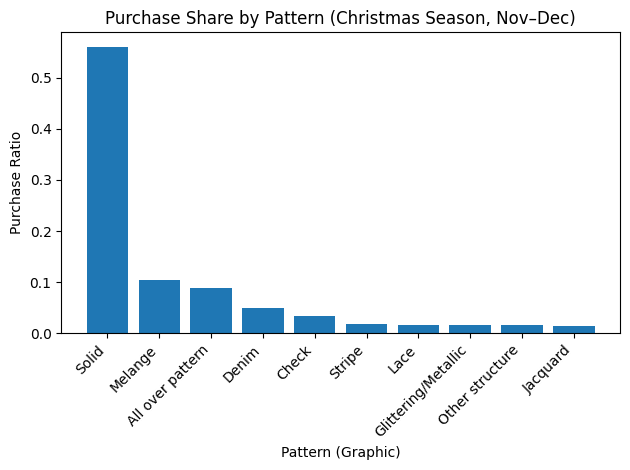

In [9]:
plt.figure()
plt.bar(
    pattern_ratio_top10["graphic"],
    pattern_ratio_top10["purchase_ratio"]
)
plt.title("Purchase Share by Pattern (Christmas Season, Nov–Dec)")
plt.xlabel("Pattern (Graphic)")
plt.ylabel("Purchase Ratio")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### 그냥 잘 팔리는 제품 아닌가?

In [10]:
# 1) 크리스마스 시즌(11~12월)에서 가장 많이 팔린 패턴 Top 5
top5_patterns = (
    analysis_christmas["graphic"]
    .value_counts()
    .head(5)
    .index
)

# 2) 전체 기간에서 Top 5 패턴 거래만 추출
pattern_all = analysis_master[
    analysis_master["graphic"].isin(top5_patterns)
].copy()

# 3) 월별 패턴 구매 횟수(분자)
pattern_month_cnt = (
    pattern_all
    .groupby(["year_month", "graphic"])
    .size()
    .reset_index(name="purchase_cnt")
)

# 4) 월별 전체 구매 횟수(분모)
monthly_total = (
    analysis_master
    .groupby("year_month")
    .size()
    .reset_index(name="total_cnt")
)

# 5) 월별 구매 비중 계산
pattern_month_ratio = pattern_month_cnt.merge(monthly_total, on="year_month", how="left")

pattern_month_ratio["purchase_ratio"] = (
    pattern_month_ratio["purchase_cnt"] / pattern_month_ratio["total_cnt"]
)

# 6) 그래프용 테이블 (월 x 패턴)
pattern_trend = (
    pattern_month_ratio
    .pivot(index="year_month", columns="graphic", values="purchase_ratio")
    .sort_index()
    .fillna(0)
)

pattern_trend.head()

graphic,All over pattern,Check,Denim,Melange,Solid
year_month,,,,,
2019-01,0.109164,0.018507,0.067170,0.081953,0.531070
2019-02,0.122121,0.016356,0.077995,0.056660,0.528207
2019-03,0.134361,0.013980,0.067094,0.044056,0.539590
2019-04,0.171245,0.007903,0.059217,0.031722,0.528772
2019-05,0.182590,0.006194,0.053037,0.028326,0.532323


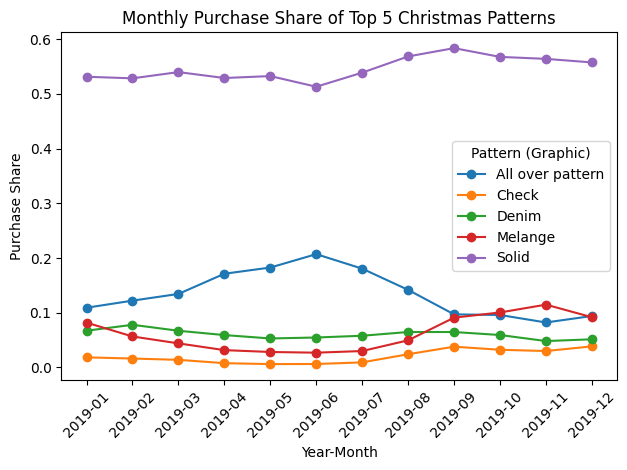

In [ ]:
# 8) (그래프) 월별 구매 비중 추이
plt.figure()
for col in pattern_trend.columns:
    plt.plot(
        pattern_trend.index,
        pattern_trend[col],
        marker="o",
        label=col
    )
plt.title("Monthly Purchase Share of Top 5 Christmas Patterns")
plt.xlabel("Year-Month")
plt.ylabel("Purchase Share")
plt.xticks(rotation=45)
plt.legend(title="Pattern (Graphic)")
plt.tight_layout()
plt.show()

### 분석결과

- Solid는 원래부터 잘 팔리는 패턴
- Denim은 여름 시즌에 강세
- Melange는 겨울시즌, 11~12월에 ‘뚜렷한 상승’세를 보인다
- Check 패턴은 소수지만 ‘연말 반등’
- All over pattern은 ‘여름 중심 → 연말 하락’

11~12월에 많이 팔린 패턴들이 모두 크리스마스 시즌 특화 패턴은 아니며, 일부 패턴은 연중 안정적인 판매 비중을 유지하는 반면, Melange 및 Check 패턴은 연말 시즌에 상대적으로 선호도가 증가하는 경향을 보였다.

### 종류는 어떨까?
1. product_type: 스웨터/니트/드래스 같은 파악이 가능하기 때문에 선택
- Dress
- Sweater
- Trousers

In [12]:
# 크리스마스 시즌 product_type Top 10 (표)
type_summary = (
    analysis_christmas
    .groupby("product_type")
    .size()
    .reset_index(name="purchase_cnt")
    .sort_values("purchase_cnt", ascending=False)
)

type_summary.head(10)


,product_type,purchase_cnt
82,Sweater,19535
91,Trousers,15283
24,Dress,10833
89,Top,5512
13,Bra,5340
9,Blouse,4806
86,T-shirt,4293
96,Underwear bottom,4100
76,Skirt,3623
50,Leggings/Tights,3066


In [13]:
type_summary = (
    analysis_christmas
    .groupby("product_type")
    .size()
    .reset_index(name="purchase_cnt")
    .sort_values("purchase_cnt", ascending=False)
)
type_summary.head(10)

,product_type,purchase_cnt
82,Sweater,19535
91,Trousers,15283
24,Dress,10833
89,Top,5512
13,Bra,5340
9,Blouse,4806
86,T-shirt,4293
96,Underwear bottom,4100
76,Skirt,3623
50,Leggings/Tights,3066


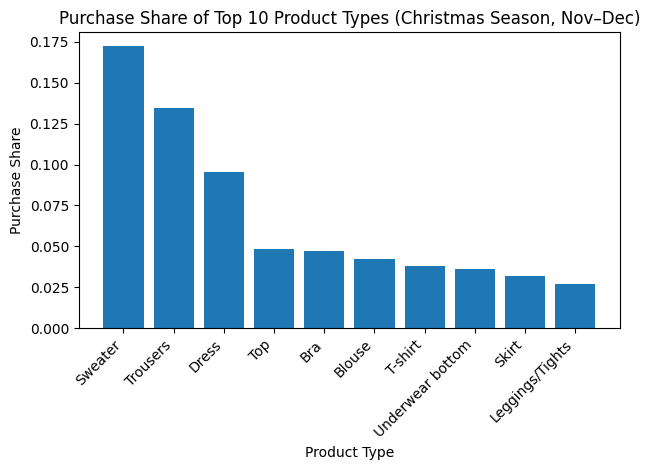

In [14]:
type_summary["purchase_ratio"] = type_summary["purchase_cnt"] / type_summary["purchase_cnt"].sum()
type_top10_ratio = type_summary.head(10)

plt.figure()
plt.bar(type_top10_ratio["product_type"], type_top10_ratio["purchase_ratio"])
plt.title("Purchase Share of Top 10 Product Types (Christmas Season, Nov–Dec)")
plt.xlabel("Product Type")
plt.ylabel("Purchase Share")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [15]:
# 크리스마스 시즌 Top 5 product_type 선정
top5_types = (
    analysis_christmas["product_type"]
    .value_counts()
    .head(5)
    .index
)

top5_types


Index(['Sweater', 'Trousers', 'Dress', 'Top', 'Bra'], dtype='str', name='product_type')

### 그냥 잘 팔리는 제품 아닌가?

In [16]:
# 전체 기간에서 Top5 종류만 뽑고 월별 비중 계산

type_all = analysis_master[
    analysis_master["product_type"].isin(top5_types)
].copy()

type_month_cnt = (
    type_all
    .groupby(["year_month", "product_type"])
    .size()
    .reset_index(name="purchase_cnt")
)

monthly_total = (
    analysis_master
    .groupby("year_month")
    .size()
    .reset_index(name="total_cnt")
)

type_month_ratio = type_month_cnt.merge(monthly_total, on="year_month", how="left")
type_month_ratio["purchase_ratio"] = type_month_ratio["purchase_cnt"] / type_month_ratio["total_cnt"]

type_trend = (
    type_month_ratio
    .pivot(index="year_month", columns="product_type", values="purchase_ratio")
    .sort_index()
    .fillna(0)
)

type_trend.head()


product_type,Bra,Dress,Sweater,Top,Trousers
year_month,,,,,
2019-01,0.046944,0.057335,0.144571,0.045719,0.158543
2019-02,0.039900,0.070965,0.099944,0.055608,0.164843
2019-03,0.036845,0.089358,0.070833,0.056159,0.159782
2019-04,0.032161,0.121206,0.028250,0.052316,0.126489
2019-05,0.036943,0.119614,0.024801,0.046674,0.109028


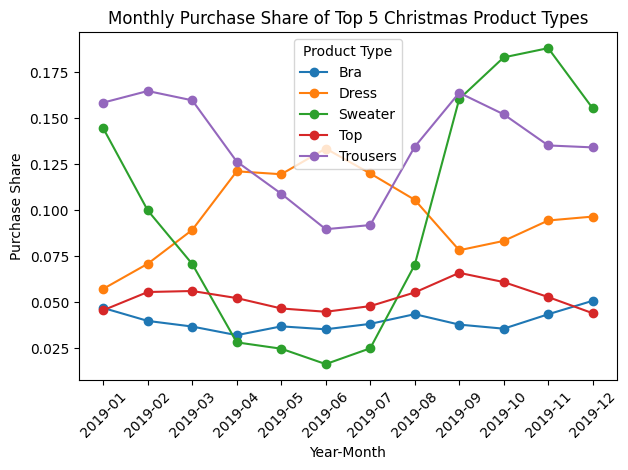

In [17]:
plt.figure()
for col in type_trend.columns:
    plt.plot(
        type_trend.index,
        type_trend[col],
        marker="o",
        label=col
    )

plt.title("Monthly Purchase Share of Top 5 Christmas Product Types")
plt.xlabel("Year-Month")
plt.ylabel("Purchase Share")
plt.xticks(rotation=45)
plt.legend(title="Product Type")
plt.tight_layout()
plt.show()

### 분석결과

- Sweater
    - 6~7월 저점이나 9월부터 급격히 상승 10~11월 최고치
    - 12월에도 하락하나 높은 수준을 유지한다.
> 겨울 시즌성 + 크리스마스 시즌 특화 상품 보온성과 연말 활용도가 반영된 결과로 보이며, 이는 시즌 판매 상품으로 적당하다 판단된다.

- Dress
    - 봄~여름까지 점진적 상승 5~6월 고점
    - 9월 이후 다시 상승
    - 11~12월 안정적으로 높은 비중을 차지함
> 연말 모임, 행사 등과 연관되어 크리스마스 시즌에 수요가 유지되거나 소폭 증가하는 상품군으로 해석할 수 있다.

- Trousers는 연중 강세지만, 연말에는 상대적 약화
    - 1~3월, 9월에 비중이 높음, 11~12월에는 상대적으로 하락
> Trousers는 연중 꾸준히 판매되는 상시 상품이나, 크리스마스 시즌에 특화된 상품으로 판매하긴 어렵다

- Bra와 Top은 시즌 영향이 제한적

크리스마스 시즌에 많이 판매되는 상품 형태를 월별 구매 비중으로 분석한 결과, Sweater와 Dress는 연말 시즌에 수요가 증가하는 경향을 보였으며, <br>특히 Sweater는 크리스마스 시즌 특화 상품으로 확인되었다. 반면 Trousers, Bra, Top은 연중 비교적 안정적인 구매 패턴을 보여 시즌성 영향이 제한적인 상품군으로 나타났다.

### 종류_2는 어떨까? (뭐라 해야할지 모르겠음....)
- garment_group
- Knitwear
- Dresses
- Outerwear
- Underwear
- Trousers

In [18]:
garment_summary = (
    analysis_christmas
    .groupby("garment_group")
    .size()
    .reset_index(name="purchase_cnt")
    .sort_values("purchase_cnt", ascending=False)
)

garment_summary.head(10)


,garment_group,purchase_cnt
7,Knitwear,17944
6,Jersey Fancy,14814
18,"Under-, Nightwear",13210
16,Trousers,10706
5,Jersey Basic,9624
0,Accessories,8381
3,Dresses Ladies,7426
1,Blouses,7023
13,Socks and Tights,5072
17,Trousers Denim,3950


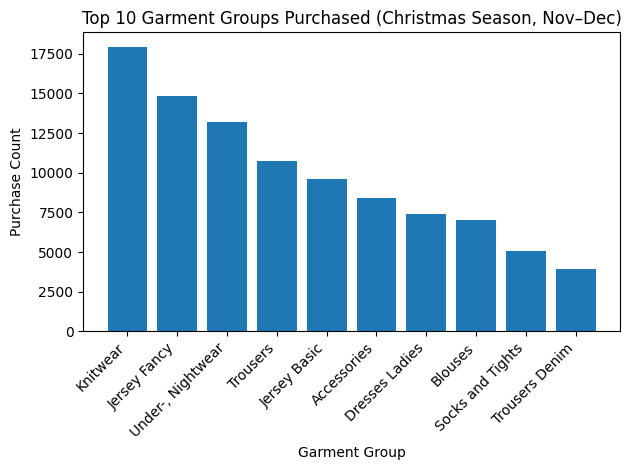

In [19]:
# Top 10 garment_group 막대그래프 (구매 횟수)
garment_top10 = garment_summary.head(10)

plt.figure()
plt.bar(
    garment_top10["garment_group"],
    garment_top10["purchase_cnt"]
)
plt.title("Top 10 Garment Groups Purchased (Christmas Season, Nov–Dec)")
plt.xlabel("Garment Group")
plt.ylabel("Purchase Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### 그냥 잘 팔리는 제품 아닌가?

In [20]:
# 크리스마스 Top 5 garment_group 월별 구매비중 추이
# Top 5 garment_group 선정
top5_garments = (
    analysis_christmas["garment_group"]
    .value_counts()
    .head(5)
    .index
)

# 전체 기간에서 Top 5만 추출
garment_all = analysis_master[
    analysis_master["garment_group"].isin(top5_garments)
].copy()

# 월별 구매 비중 계산
garment_month_cnt = (
    garment_all
    .groupby(["year_month", "garment_group"])
    .size()
    .reset_index(name="purchase_cnt")
)

monthly_total = (
    analysis_master
    .groupby("year_month")
    .size()
    .reset_index(name="total_cnt")
)

garment_month_ratio = garment_month_cnt.merge(
    monthly_total,
    on="year_month",
    how="left"
)

garment_month_ratio["purchase_ratio"] = (
    garment_month_ratio["purchase_cnt"]
    / garment_month_ratio["total_cnt"]
)

garment_trend = (
    garment_month_ratio
    .pivot(
        index="year_month",
        columns="garment_group",
        values="purchase_ratio"
    )
    .sort_index()
    .fillna(0)
)


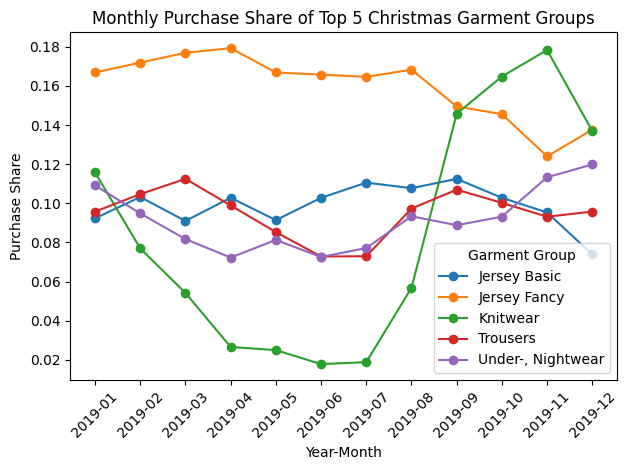

In [21]:
plt.figure()
for col in garment_trend.columns:
    plt.plot(
        garment_trend.index,
        garment_trend[col],
        marker="o",
        label=col
    )

plt.title("Monthly Purchase Share of Top 5 Christmas Garment Groups")
plt.xlabel("Year-Month")
plt.ylabel("Purchase Share")
plt.xticks(rotation=45)
plt.legend(title="Garment Group")
plt.tight_layout()
plt.show()


### 분석결과

- Knitwear
    - 6~7월 구매 비중이 가장 낮아 연중 저점을 형성한다.
    - 8월부터 빠르게 상승하기 시작하여 9~11월 급격한 증가를 보인다.
    - 11월 최고치를 기록한 후, 12월에도 높은 수준을 유지한다.
    
> 전형적인 겨울 시즌성 상품군으로, 보온성과 계절 수요가 명확하게 반영된 결과이다. 특히 9월 이후 급격한 상승은 크리스마스 및 연말 시즌 소비와 직접적으로 연결된 것으로 해석할 수 있으며, 크리스마스 시즌 핵심 전략 상품군으로 적합하다 판단된다.

- Jersey Basic
    - 연중 비교적 안정적인 구매 비중을 유지한다.
    - 6~9월 소폭 상승하며, 9월에 가장 높은 수준을 보인다.
    - 10월 이후 하락세를 보이며 12월에는 연중 최저 수준에 근접한다.

> 기본 이너웨어 성격의 상품군으로, 계절이나 이벤트보다는 상시 소비 목적이 강한 것으로 해석된다. 때문에 크리스마스 시즌 특화 상품으로 활용하기에는 적합성이 낮다 판단된다

- Jersey Fancy
    - 1~4월 높은 구매 비중을 유지하며, 상반기 전반에 강세를 보이고 여름철(6~7월) 소폭 하락 후 8월 반등한다.
    - 9월 이후 지속적으로 감소하여 11~12월에는 연중 최저 수준을 기록한다.

> 디자인 요소가 강조된 저지류로 판단되며, 계절성보다는 데일리·캐주얼 수요 중심 상품군으로 보인다. 크리스마스 시즌과의 직접적인 연관성은 제한적인 것으로 판단된다.

- Trousers
    - 연중 구매 비중 변동 폭이 크지 않다.
> 하의류 특성상 계절 이벤트보다는 실용적 소비가 중심인 상품군으로 보인다. 크리스마스 시즌 특화 상품보다는 상시 판매 유지 전략이 적합하다 판단된다.

- Underwear / Nightwear
    - 상반기에는 비교적 낮은 수준을 유지하다, 9월 이후 점진적으로 상승하여 12월에 연중 최고점에 도달한다.

> 선물 수요 및 연말 소비 증가의 영향을 받은 것으로 해석된다. 크리스마스 시즌에 맞춘 상품 전략에 활용 가능성이 높은 상품군으로 판단된다.

크리스마스 시즌에 대한 월별 구매 비중 분석 결과, Knitwear와 Underwear/Nightwear는 연말 시즌에 수요가 뚜렷하게 증가하는 상품군으로 확인되었다. 특히 Knitwear는 9월 이후 급격한 상승과 11월 최고치를 기록하며,
크리스마스 시즌 특화 핵심 상품군으로 분류할 수 있다.

반면 Jersey Basic, Jersey Fancy, Trousers는 연중 비교적 안정적인 구매 패턴을 보이며
시즌성 이벤트의 영향은 제한적인 것으로 나타났다.

### 고객 타겟 파악 index_group

In [22]:
index_group_summary = (
    analysis_christmas
    .groupby("index_group")
    .size()
    .reset_index(name="purchase_cnt")
    .sort_values("purchase_cnt", ascending=False)
)

index_group_summary


,index_group,purchase_cnt
2,Ladieswear,72877
1,Divided,25237
3,Menswear,8386
4,Sport,3739
0,Baby/Children,3181


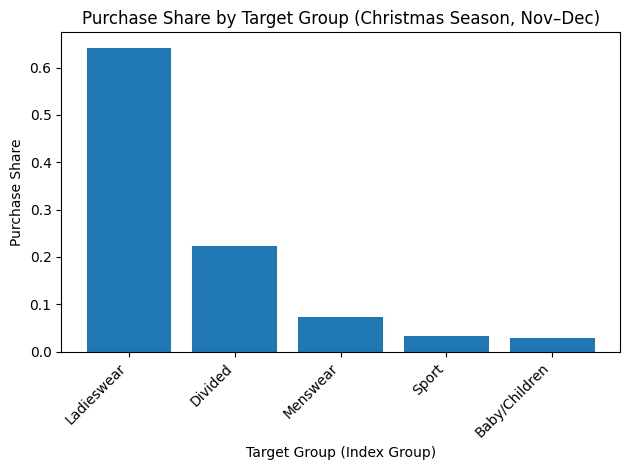

In [23]:
index_group_summary["purchase_ratio"] = (
    index_group_summary["purchase_cnt"]
    / index_group_summary["purchase_cnt"].sum()
)

plt.figure()
plt.bar(
    index_group_summary["index_group"],
    index_group_summary["purchase_ratio"]
)
plt.title("Purchase Share by Target Group (Christmas Season, Nov–Dec)")
plt.xlabel("Target Group (Index Group)")
plt.ylabel("Purchase Share")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### 그냥 잘 팔리는 제품 아닌가?

In [24]:
# 월별 × 고객타겟 구매 횟수 집계
index_month_cnt = (
    analysis_master
    .groupby(["year_month", "index_group"])
    .size()
    .reset_index(name="purchase_cnt")
)

# 그래프용 테이블로 변환 (pivot)
index_trend = (
    index_month_cnt
    .pivot(
        index="year_month",
        columns="index_group",
        values="purchase_cnt"
    )
    .sort_index()
    .fillna(0)
)


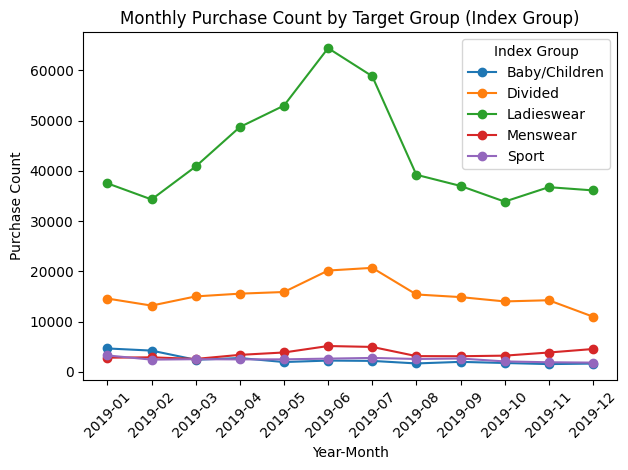

In [25]:
plt.figure()
for col in index_trend.columns:
    plt.plot(
        index_trend.index,
        index_trend[col],
        marker="o",
        label=col
    )

plt.title("Monthly Purchase Count by Target Group (Index Group)")
plt.xlabel("Year-Month")
plt.ylabel("Purchase Count")
plt.xticks(rotation=45)
plt.legend(title="Index Group")
plt.tight_layout()
plt.show()


- Baby / Children
    - 1~3월 비교적 높은 구매 건수를 보이나 이후 점진적으로 감소한다.
    - 6~7월 이후 하락세가 뚜렷하며, 10~12월에는 연중 최저 수준을 유지한다.
    
> 아동복 특성으로 인해 연말 이벤트성 소비와의 연관성은 낮은 것으로 해석되며 크리스마스 시즌 주력 타겟으로 삼기에는 적합도가 낮다 판단된다.

- Divided
    - 상반기(1~7월) 구매 건수가 꾸준히 증가하다 6~7월에 최고치를 기록한다.
    - 이후 8월부터 감소하고 10~12월에는 하락세가 이어진다.
    
> 캐주얼·트렌디 소비 중심 타겟으로, 여름 시즌 수요가 강하게 반영된 결과로 확인된다.  크리스마스 시즌 주력 타겟으로 삼기에는 적합도가 낮다 판단된다.

- Ladieswear
    - 1~6월 지속적인 상승을 보이며, 6월에 연중 최고치를 기록한다.
    - 7월 이후 급격히 감소하나, 10~12월에도 일정 수준의 구매 건수를 유지한다
    
> 전체 매출을 견인하는 핵심 타겟 그룹으로, 연말 시즌에도 기본 수요가 안정적으로 유지된다. 크리스마스 시즌 특화 상품 기획 시 가장 우선적으로 고려해야 할 주력 고객군으로 판단된다.

- Menswear
    - 상반기 점진적으로 증가하여 6월에 소폭 최고치를 기록하다 이후 감소한다.
    - 10월 이후 다시 상승하는 흐름을 보이며 11~12월에는 연말 소비 회복이 관찰된다.
> 연말 선물 수요 및 시즌성 소비가 반영된 것으로 해석된다. 크리스마스 시즌 한정 기획, 선물형 상품 구성에 적합한 타겟 그룹으로 판단된다.

- Sport
    - 연중 구매 건수 변동 폭이 크지 않다.
> 운동·기능성 중심 소비 특성으로 인해 계절 이벤트의 영향이 제한적인 그룹으로 크리스마스 시즌과의 직접적인 연관성은 낮다 판단된다.

크리스마스 시즌 기준으로 타겟 고객군의 구매 패턴을 분석한 결과, Ladieswear와 Menswear는 연말 시즌에도 비교적 안정적인 구매 건수를 유지하거나 회복하는 경향을 보였다. 특히 Menswear는 10월 이후 반등 흐름이 나타나며, 연말 선물 수요와 연관된 크리스마스 시즌 타겟 그룹으로 해석할 수 있다.<br>
또한 Ladieswearsms 전체 매출을 견인하는 핵심 타겟 그룹으로 Ladieswear를 중심으로 한 핵심 매출 유지 전략을 수립하는것이 타당하다.

### 라인 분석

In [26]:
# 크리스마스 시즌 section별 구매 횟수 (표)
section_summary = (
    analysis_christmas
    .groupby("section")
    .size()
    .reset_index(name="purchase_cnt")
    .sort_values("purchase_cnt", ascending=False)
)

section_summary.head(10)


,section,purchase_cnt
43,Womens Everyday Collection,25190
12,Divided Collection,13261
45,Womens Lingerie,8976
51,Womens Tailoring,8247
46,"Womens Nightwear, Socks & Tigh",7373
11,Divided Basics,4161
42,Womens Everyday Basics,3799
41,Womens Casual,3514
26,Ladies H&M Sport,3488
25,Ladies Denim,3167


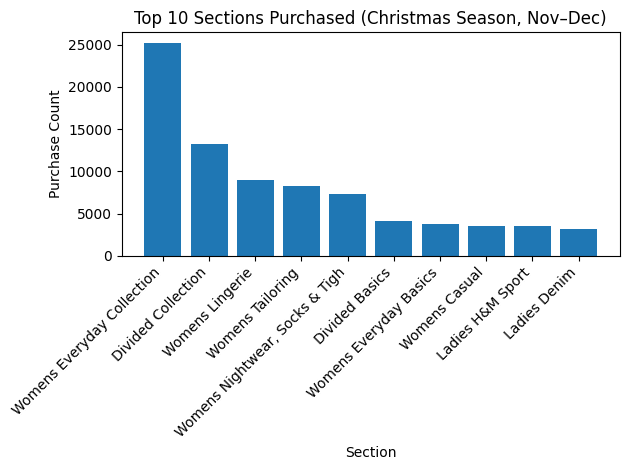

In [27]:
section_top10 = section_summary.head(10)

plt.figure()
plt.bar(
    section_top10["section"],
    section_top10["purchase_cnt"]
)
plt.title("Top 10 Sections Purchased (Christmas Season, Nov–Dec)")
plt.xlabel("Section")
plt.ylabel("Purchase Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### 그냥 잘 팔리는 제품 아닌가?

In [28]:
# 크리스마스 시즌 Top 5 section 선정
top5_sections = (
    analysis_christmas["section"]
    .value_counts()
    .head(5)
    .index
)

# 전체 기간에서 Top 5 section만 추출
section_all = analysis_master[
    analysis_master["section"].isin(top5_sections)
].copy()

# 월별 구매 횟수 집계
section_month_cnt = (
    section_all
    .groupby(["year_month", "section"])
    .size()
    .reset_index(name="purchase_cnt")
)



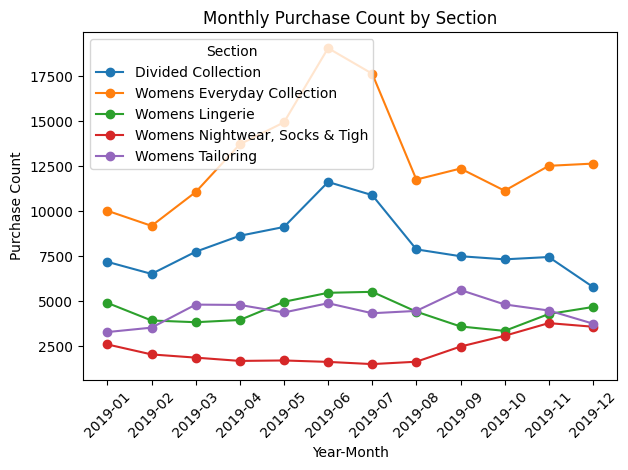

In [29]:
# 그래프용 테이블 + 시계열 그래프
section_trend = (
    section_month_cnt
    .pivot(
        index="year_month",
        columns="section",
        values="purchase_cnt"
    )
    .sort_index()
    .fillna(0)
)

plt.figure()
for col in section_trend.columns:
    plt.plot(
        section_trend.index,
        section_trend[col],
        marker="o",
        label=col
    )

plt.title("Monthly Purchase Count by Section")
plt.xlabel("Year-Month")
plt.ylabel("Purchase Count")
plt.xticks(rotation=45)
plt.legend(title="Section")
plt.tight_layout()
plt.show()


### 분석결과

- Divided Collection
    - 1~6월까지 점진적인 증가세를 보이며, 6월에 최고치를 기록한다.
    - 허나 7월 이후 급격히 감소하여 10~12월에는 낮은 수준을 유지한다.
> 캐주얼·트렌디 소비 중심 섹션으로, 여름 시즌 수요가 강하게 반영된 결과이다.

- Womens Everyday Collection
    - 전 기간 동안 가장 높은 구매 건수를 기록한다.
    - 3~7월 지속적인 상승으로 6~7월 최고치를 형성하다 8월 이후로 감소한다.
    - 10~12월에서 안정적인 구매 건수를 유지한다.

> 여성 일상복 수요를 담당하는 핵심 섹션으로, 시즌 변화에도 기본 수요가 유지되는 구조이기 때문에 크리스마스 시즌에는 주력 유지형 상품군으로 적합하다 판단된다.

- Womens Lingerie
    - 상반기 완만한 상승 후 6~7월 고점을 형성한다.
    - 8~10월 하락세를 보이나, 11~12월 다시 반등한다.

> 연말 선물 수요 및 시즌성 소비가 반영된 흐름으로 해석된다. 크리스마스 시즌 기프트 세트, 패키지 상품 구성에 적합한 섹션으로 판단된다.

- Womens Nightwear, Socks & Tights
    - 상반기 낮은 구매 건수를 유지하다. 9월 이후 뚜렷한 상승세를 보인다.
    - 이후 11~12월에 연중 최고 수준에 도달한다.
> 보온성·실내 착용 목적 수요가 연말 시즌에 집중된 것으로 해석된다. 크리스마스 시즌 특화 섹션으로 가장 명확한 시즌성을 보인다.

- Womens Tailoring
    - 연중 구매 건수 변동 폭이 크지 않으며 9월에 소폭 상승하나, 이후 다시 감소한다.
> 시즌 이벤트보다는 상시 소비 성향이 강한 것으로 보인다. 크리스마스 시즌 집중 전략엔 적합하지 않다고 판단된다.

크리스마스 시즌 기준으로 월별 구매 건수 분석 결과, Womens Nightwear, Socks & Tights와 Womens Lingerie는 크리스마스 시즌에 구매 건수가 뚜렷하게 증가하는 섹션으로 확인되었다. 특히 Nightwear, Socks & Tights는 9월 이후 지속적인 상승과 11~12월 최고치를 기록하며 연말·크리스마스 시즌 특화 핵심 섹션으로 분류할 수 있다.

# 